In [23]:
# Imports
import matplotlib.pyplot as plt
import math

In [6]:
# --- Step 1: Load and Parse Data ---
with open("data/housing-complete.csv", 'r') as f:
    lines = f.readlines()

column_names = lines[0].strip().split(',')
target = 'median_house_value'
features = [
    'longitude', 'latitude', 'housing_median_age',
    'total_rooms', 'total_bedrooms', 'population',
    'households', 'median_income'
]

feature_indexes = [column_names.index(c) for c in features]
target_index = column_names.index(target)

In [9]:
# Convert to float and clean by skipping incomplete rows
data = []
for line in lines[1:]:
    values=line.strip().split(',')

    missing=False
    for i in feature_indexes+[target_index]:
        if(i>=len(values) or values[i].strip()==''):
            missing=True
            break
    if missing:
        continue

    feature_values=[]
    for i in feature_indexes:
        feature_values.append(float(values[i].strip()))
    data.append(feature_values)


In [10]:
# Split into training (20k) and test (rest) ---
train_data = data[:20000]
test_data = data[20000:]

X_train = [row[:-1] for row in train_data]
y_train = [row[-1] for row in train_data]

X_test_raw = [row[:-1] for row in test_data]
y_test = [row[-1] for row in test_data]

# Normalize (min-max using TRAIN stats only) ---
def get_min_max(X):
    num_features = len(X[0])
    mins = [min([row[i] for row in X]) for i in range(num_features)]
    maxs = [max([row[i] for row in X]) for i in range(num_features)]
    return mins, maxs

def normalize_given(X, mins, maxs):
    normalized = []
    for row in X:
        new_row = []
        for i in range(len(row)):
            if maxs[i] == mins[i]:
                new_row.append(0.0)
            else:
                val = (row[i] - mins[i]) / (maxs[i] - mins[i])
                new_row.append(val)
        normalized.append(new_row)
    return normalized

mins, maxs = get_min_max(X_train)
X_train = normalize_given(X_train, mins, maxs)
X_test = normalize_given(X_test_raw, mins, maxs)

# Code for Implementation type 1: Pure Python

In [11]:
# ----------- Dot Product -----------
def dot_product(a, b):
    return sum(a[i] * b[i] for i in range(len(a)))

# ----------- Compute Cost -----------
def compute_cost(X, y, Ws, b):
    n = len(X)
    total_error = 0.0
    for i in range(n):
        y_pred = dot_product(Ws, X[i]) + b
        total_error += (y_pred - y[i]) ** 2
    return total_error / (2 * n)

# ----------- Gradient Descent -----------
def gradient_descent(X, y, alpha=0.01, epsilon=0.001, max_itr=1000):
    m = len(X[0])       # number of features
    n = len(X)          # number of samples
    Ws = [0.0] * m      # weights
    b = 0.0             # bias

    previous_cost = float('inf')
    cost_history = []

    for itr in range(max_itr):
        dw = [0.0] * m
        db = 0.0

        # Compute gradients
        for i in range(n):
            y_pred = dot_product(Ws, X[i]) + b
            error = y_pred - y[i]
            for j in range(m):
                dw[j] += error * X[i][j]
            db += error

        # Update weights and bias
        for j in range(m):
            Ws[j] -= (alpha * dw[j]) / n
        b -= (alpha * db) / n

        # Compute and store cost
        current_cost = compute_cost(X, y, Ws, b)
        cost_history.append(current_cost)

        if abs(previous_cost - current_cost) < epsilon:
            print(f"Converged at iteration {itr}, Cost = {current_cost:.6f}")
            break

        previous_cost = current_cost

        if itr % 100 == 0:
            print(f"Iteration {itr}: Cost = {current_cost:.6f}")

    return Ws, b, cost_history

# ----------- Predict Function -----------
def predict(x, Ws, b):
    return dot_product(x, Ws) + b


In [18]:
# Train the model
Ws, b, cost_history = gradient_descent(X_train, y_train, alpha=0.001, epsilon=0.0001, max_itr = 2000)

Iteration 0: Cost = 9.239933
Iteration 100: Cost = 7.176731
Iteration 200: Cost = 5.696566
Iteration 300: Cost = 4.634583
Iteration 400: Cost = 3.872541
Iteration 500: Cost = 3.325632
Iteration 600: Cost = 2.933030
Iteration 700: Cost = 2.651107
Iteration 800: Cost = 2.448570
Iteration 900: Cost = 2.302975
Iteration 1000: Cost = 2.198226
Iteration 1100: Cost = 2.122775
Iteration 1200: Cost = 2.068342
Iteration 1300: Cost = 2.028987
Iteration 1400: Cost = 2.000449
Iteration 1500: Cost = 1.979673
Iteration 1600: Cost = 1.964467
Converged at iteration 1688, Cost = 1.954434


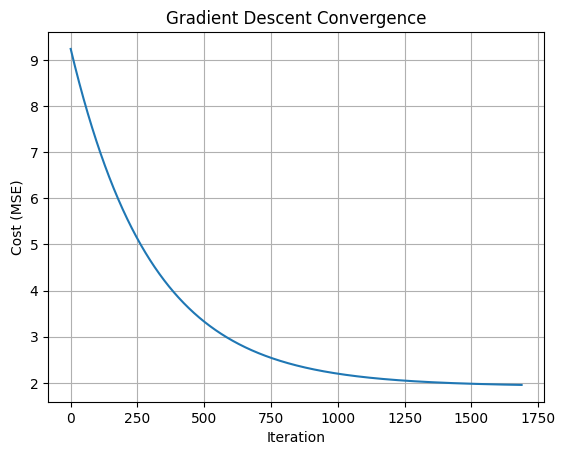

In [19]:
# Plot cost vs. iterations
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost (MSE)")
plt.title("Gradient Descent Convergence")
plt.grid(True)
plt.show()

In [29]:
def evaluate_model(y_true, y_pred):
    n = len(y_true)
    mae = sum(abs(y_true[i] - y_pred[i]) for i in range(n)) / n
    mse = sum((y_true[i] - y_pred[i]) ** 2 for i in range(n)) / n
    rmse = math.sqrt(mse)
    mean_y = sum(y_true) / n
    ss_tot = sum((y_true[i] - mean_y) ** 2 for i in range(n))
    ss_res = sum((y_true[i] - y_pred[i]) ** 2 for i in range(n))
    r2 = 1 - (ss_res / ss_tot)
    return mae, rmse, r2



In [30]:
y_pred = [predict(x, Ws, b) for x in X_test]

# Evaluate on test set
mae_pure, rmse_pure, r2_pure = evaluate_model(y_test, y_pred)
print(f"Test MAE: {mae_pure:.2f}")
print(f"Test RMSE: {rmse_pure:.2f}")
print(f"Test R2 Score: {r2_pure:.4f}")

Test MAE: 1.61
Test RMSE: 2.09
Test R2 Score: -0.2859


# Code for Implementation type 2: Using Numpy